In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier, Pool, cv
from lib import preprocess
import optuna
from tqdm import tqdm

### Load Data

In [3]:
path_data = Path("../data")
train = pd.read_csv(path_data / "train.csv")
test = pd.read_csv(path_data / "test.csv")

In [4]:
train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


### Prepare Data

In [ ]:
# Define columns
numerical_columns = ["Age", "Work/Study Hours"]
quantized_columns = ["CGPA"]

# Define text columns
text_columns = [
    "Name",
    "City",
    "Profession",
    "Sleep Duration",
    "Degree",
    "Dietary Habits",
]

# Define categorical columns and include text columns
categorical_columns = [
    "Gender",
    "Working Professional or Student",
    "Have you ever had suicidal thoughts ?",
    "Financial Stress",
    "Family History of Mental Illness",
] + text_columns

# Drop duplicates
train = train.drop_duplicates()
test = test.drop_duplicates()

# Make copies of the dataframes for preprocessing
train_preprocessed = train.copy()
test_preprocessed = test.copy()

# Drop 'id' column if it exists
if "id" in train_preprocessed.columns:
    train_preprocessed = train_preprocessed.drop(columns="id")
if "id" in test_preprocessed.columns:
    test_preprocessed = test_preprocessed.drop(columns="id")

# Fill missing values and encode categorical columns
for col in categorical_columns:
    # Fill missing values with mode or 'missing' if mode is not available
    if train_preprocessed[col].mode().empty:
        fill_value = "missing"
    else:
        fill_value = train_preprocessed[col].mode()[0]
    train_preprocessed[col] = train_preprocessed[col].fillna(fill_value)
    test_preprocessed[col] = test_preprocessed[col].fillna(fill_value)

    # Encode categorical columns
    le = LabelEncoder()
    le.fit(pd.concat([train_preprocessed[col], test_preprocessed[col]]).astype(str))

    train_preprocessed[col] = le.transform(train_preprocessed[col].astype(str))
    test_preprocessed[col] = le.transform(test_preprocessed[col].astype(str))

    # Convert to 'category' data type
    train_preprocessed[col] = train_preprocessed[col].astype("category")
    test_preprocessed[col] = test_preprocessed[col].astype("category")

# Fill missing values and process numerical columns
for col in numerical_columns + quantized_columns:
    median_value = train_preprocessed[col].median()
    train_preprocessed[col] = train_preprocessed[col].fillna(median_value)
    test_preprocessed[col] = test_preprocessed[col].fillna(median_value)
    train_preprocessed[col] = train_preprocessed[col].astype(float)
    test_preprocessed[col] = test_preprocessed[col].astype(float)

# Transform 'Age' to integer
train_preprocessed["Age"] = train_preprocessed["Age"].astype(int)
test_preprocessed["Age"] = test_preprocessed["Age"].astype(int)

# Create age groups
train_preprocessed["Age_Group"] = pd.cut(
    train_preprocessed["Age"], bins=3, labels=False
)
test_preprocessed["Age_Group"] = pd.cut(test_preprocessed["Age"], bins=3, labels=False)

# Ensure 'Academic Pressure' and 'Work Pressure' columns are numeric before merging
train_preprocessed["Academic Pressure"] = train_preprocessed[
    "Academic Pressure"
].astype(float)
train_preprocessed["Work Pressure"] = train_preprocessed["Work Pressure"].astype(float)
test_preprocessed["Academic Pressure"] = test_preprocessed["Academic Pressure"].astype(
    float
)
test_preprocessed["Work Pressure"] = test_preprocessed["Work Pressure"].astype(float)

# Merge 'Academic Pressure' and 'Work Pressure' columns to create 'Pressure'. Clip values to [0, 5] range because pressure cannot be negative and is capped at 5
train_preprocessed["Pressure"] = (
    train_preprocessed["Academic Pressure"].fillna(0)
    + train_preprocessed["Work Pressure"].fillna(0)
).clip(0, 5)
test_preprocessed["Pressure"] = (
    test_preprocessed["Academic Pressure"].fillna(0)
    + test_preprocessed["Work Pressure"].fillna(0)
).clip(0, 5)

# Ensure 'Study Satisfaction' and 'Job Satisfaction' columns are numeric before merging
train_preprocessed["Study Satisfaction"] = train_preprocessed[
    "Study Satisfaction"
].astype(float)
train_preprocessed["Job Satisfaction"] = train_preprocessed["Job Satisfaction"].astype(
    float
)
test_preprocessed["Study Satisfaction"] = test_preprocessed[
    "Study Satisfaction"
].astype(float)
test_preprocessed["Job Satisfaction"] = test_preprocessed["Job Satisfaction"].astype(
    float
)

# Merge 'Study Satisfaction' and 'Job Satisfaction' columns to create 'Satisfaction' column. Clip values to [0, 5] range because satisfaction cannot be negative and is capped at 5
train_preprocessed["Satisfaction"] = (
    train_preprocessed["Study Satisfaction"].fillna(0)
    + train_preprocessed["Job Satisfaction"].fillna(0)
).clip(0, 5)
test_preprocessed["Satisfaction"] = (
    test_preprocessed["Study Satisfaction"].fillna(0)
    + test_preprocessed["Job Satisfaction"].fillna(0)
).clip(0, 5)

# Add 'Pressure' and 'Satisfaction' to numerical columns if not already included
for col in ["Pressure", "Satisfaction"]:
    if col not in numerical_columns:
        numerical_columns.append(col)

# Drop 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction' columns
train_preprocessed = train_preprocessed.drop(
    columns=["Academic Pressure", "Work Pressure", "Study Satisfaction", "Job Satisfaction"]
)
test_preprocessed = test_preprocessed.drop(
    columns=["Academic Pressure", "Work Pressure", "Study Satisfaction", "Job Satisfaction"]
)


# Create interaction features
new_categorical_features = []
new_numerical_features = []


# 1. Pressure and Satisfaction Interaction
train_preprocessed["Pressure_Satisfaction"] = (
    train_preprocessed["Pressure"] / train_preprocessed["Satisfaction"]
)
test_preprocessed["Pressure_Satisfaction"] = (
    test_preprocessed["Pressure"] / test_preprocessed["Satisfaction"]
)
new_numerical_features.append("Pressure_Satisfaction")

# 4. Work/Study Hours and Pressure Interaction
train_preprocessed["WorkHours_Pressure"] = (
    train_preprocessed["Work/Study Hours"] * train_preprocessed["Pressure"]
)
test_preprocessed["WorkHours_Pressure"] = (
    test_preprocessed["Work/Study Hours"] * test_preprocessed["Pressure"]
)
new_numerical_features.append("WorkHours_Pressure")


# 6. Dietary Habits and Sleep Duration Interaction
train_preprocessed["Diet_Sleep"] = (
    train_preprocessed["Dietary Habits"].astype(str)
    + "_"
    + train_preprocessed["Sleep Duration"].astype(str)
)
test_preprocessed["Diet_Sleep"] = (
    test_preprocessed["Dietary Habits"].astype(str)
    + "_"
    + test_preprocessed["Sleep Duration"].astype(str)
)
new_categorical_features.append("Diet_Sleep")

# 7. Financial Stress and Work/Study Hours Interaction
train_preprocessed["FinancialStress_WorkHours"] = (
    train_preprocessed["Financial Stress"].astype(int)
    * train_preprocessed["Work/Study Hours"]
)
test_preprocessed["FinancialStress_WorkHours"] = (
    test_preprocessed["Financial Stress"].astype(int)
    * test_preprocessed["Work/Study Hours"]
)
new_numerical_features.append("FinancialStress_WorkHours")

# 8. Gender and Suicidal Thoughts Interaction
train_preprocessed["Gender_SuicidalThoughts"] = (
    train_preprocessed["Gender"].astype(str)
    + "_"
    + train_preprocessed["Have you ever had suicidal thoughts ?"].astype(str)
)
test_preprocessed["Gender_SuicidalThoughts"] = (
    test_preprocessed["Gender"].astype(str)
    + "_"
    + test_preprocessed["Have you ever had suicidal thoughts ?"].astype(str)
)
new_categorical_features.append("Gender_SuicidalThoughts")

# 9. Family History and Age Interaction
train_preprocessed["Age_FamilyHistory"] = train_preprocessed[
    "Age"
] * train_preprocessed["Family History of Mental Illness"].astype(int)
test_preprocessed["Age_FamilyHistory"] = test_preprocessed["Age"] * test_preprocessed[
    "Family History of Mental Illness"
].astype(int)
new_numerical_features.append("Age_FamilyHistory")

# 10. Work/Study Hours and Satisfaction Interaction
train_preprocessed["WorkHours_Satisfaction"] = (
    train_preprocessed["Work/Study Hours"] / train_preprocessed["Satisfaction"]
)
test_preprocessed["WorkHours_Satisfaction"] = (
    test_preprocessed["Work/Study Hours"] / test_preprocessed["Satisfaction"]
)
new_numerical_features.append("WorkHours_Satisfaction")

# Update feature lists
categorical_columns.extend(new_categorical_features)
numerical_columns.extend(new_numerical_features)

# Encode new categorical interaction features
for col in new_categorical_features:
    le = LabelEncoder()
    le.fit(pd.concat([train_preprocessed[col], test_preprocessed[col]]).astype(str))
    train_preprocessed[col] = le.transform(train_preprocessed[col].astype(str))
    test_preprocessed[col] = le.transform(test_preprocessed[col].astype(str))
    train_preprocessed[col] = train_preprocessed[col].astype("category")
    test_preprocessed[col] = test_preprocessed[col].astype("category")

# Ensure all numerical columns are of float type
for col in numerical_columns:
    train_preprocessed[col] = train_preprocessed[col].astype(float)
    test_preprocessed[col] = test_preprocessed[col].astype(float)

# Quantize 'CGPA' into 'Low', 'Medium', 'High' categories
train_preprocessed["CGPA"] = pd.cut(
    train_preprocessed["CGPA"],
    bins=3,
    labels=["Low", "Medium", "High"],
    duplicates="drop",
)
test_preprocessed["CGPA"] = pd.cut(
    test_preprocessed["CGPA"],
    bins=3,
    labels=["Low", "Medium", "High"],
    duplicates="drop",
)

# Since 'CGPA' is now categorical, update the feature lists
if "CGPA" in quantized_columns:
    quantized_columns.remove("CGPA")
categorical_columns.append("CGPA")

# Encode 'CGPA' as categorical
le = LabelEncoder()
le.fit(pd.concat([train_preprocessed["CGPA"], test_preprocessed["CGPA"]]).astype(str))
train_preprocessed["CGPA"] = le.transform(train_preprocessed["CGPA"].astype(str))
test_preprocessed["CGPA"] = le.transform(test_preprocessed["CGPA"].astype(str))
train_preprocessed["CGPA"] = train_preprocessed["CGPA"].astype("category")
test_preprocessed["CGPA"] = test_preprocessed["CGPA"].astype("category")

In [77]:
train_preprocessed.dtypes

Name                                     category
Gender                                   category
Age                                       float64
City                                     category
Working Professional or Student          category
Profession                               category
CGPA                                     category
Sleep Duration                           category
Dietary Habits                           category
Degree                                   category
Have you ever had suicidal thoughts ?    category
Work/Study Hours                          float64
Financial Stress                         category
Family History of Mental Illness         category
Depression                                  int64
Age_Group                                   int64
Pressure                                  float64
Satisfaction                              float64
Pressure_Satisfaction                     float64
WorkHours_Pressure                        float64


In [78]:
# Convert categorical columns to strings to avoid CatBoost errors
for col in categorical_columns:
    train_preprocessed[col] = train_preprocessed[col].astype(str)
    test_preprocessed[col] = test_preprocessed[col].astype(str)


# Prepare data
X = train_preprocessed.drop(columns=["Depression"])
y = train_preprocessed["Depression"]
X_test = test_preprocessed

# Initialize arrays to store out-of-fold predictions and test predictions
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

# Stratified K-Fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

with tqdm(total=n_splits, desc="Folds") as pbar:
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Create Pool objects for CatBoost with categorical columns only
        train_pool = Pool(
            data=X_train_fold,
            label=y_train_fold,
            cat_features=categorical_columns,
        )
        val_pool = Pool(
            data=X_val_fold,
            label=y_val_fold,
            cat_features=categorical_columns,
        )

        # Initialize and train the model
        model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            loss_function="Logloss",
            eval_metric="Accuracy",
            random_seed=42,
            logging_level="Silent",
        )
        model.fit(train_pool, eval_set=val_pool)

        # Predict on validation fold
        oof_preds[val_idx] = model.predict_proba(val_pool)[:, 1]

        # Predict on test set and accumulate predictions
        test_pool = Pool(
            data=X_test,
            cat_features=categorical_columns,
        )
        test_preds += model.predict_proba(test_pool)[:, 1] / n_splits

        pbar.update(1)

# Evaluate out-of-fold predictions
auc_score = roc_auc_score(y, oof_preds)
accuracy = accuracy_score(y, (oof_preds >= 0.5).astype(int))
print(f"Out-of-Fold ROC AUC: {auc_score:.4f}")
print(f"Out-of-Fold Accuracy: {accuracy:.4f}")

# Generate final predictions on test set
y_test_pred = (test_preds >= 0.5).astype(int)

# Save predictions to submission file
submission = pd.read_csv(path_data / "sample_submission.csv")
submission["Depression"] = y_test_pred
submission.to_csv(path_data / "submission.csv", index=False)
submission.head()

KeyError: 'Academic Pressure'

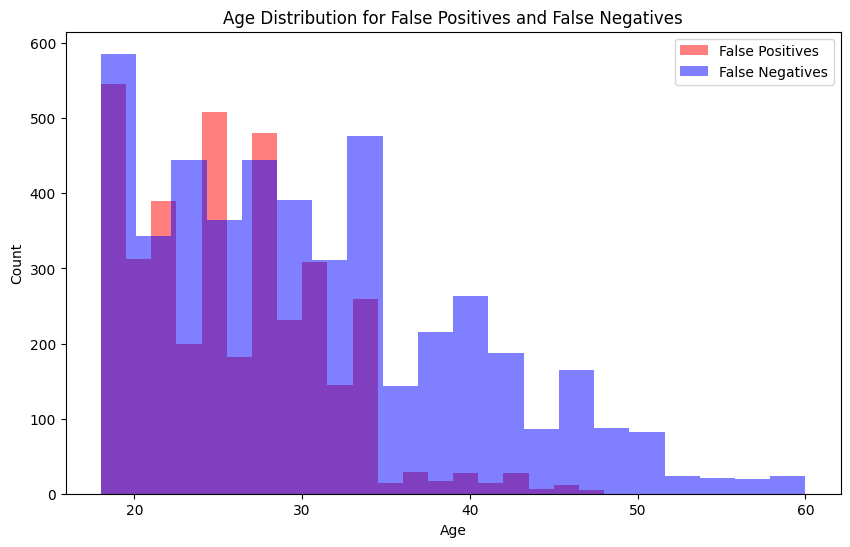

In [ ]:
# Get false positive and false negative indices for 'age' column
fp_idx = (oof_preds >= 0.5) & (y == 0)
fn_idx = (oof_preds < 0.5) & (y == 1)

# Plot 'age' distribution for false positives and false negatives
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(X["Age"][fp_idx], bins=20, alpha=0.5, label="False Positives", color="red")
plt.hist(X["Age"][fn_idx], bins=20, alpha=0.5, label="False Negatives", color="blue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.title("Age Distribution for False Positives and False Negatives")
plt.show()

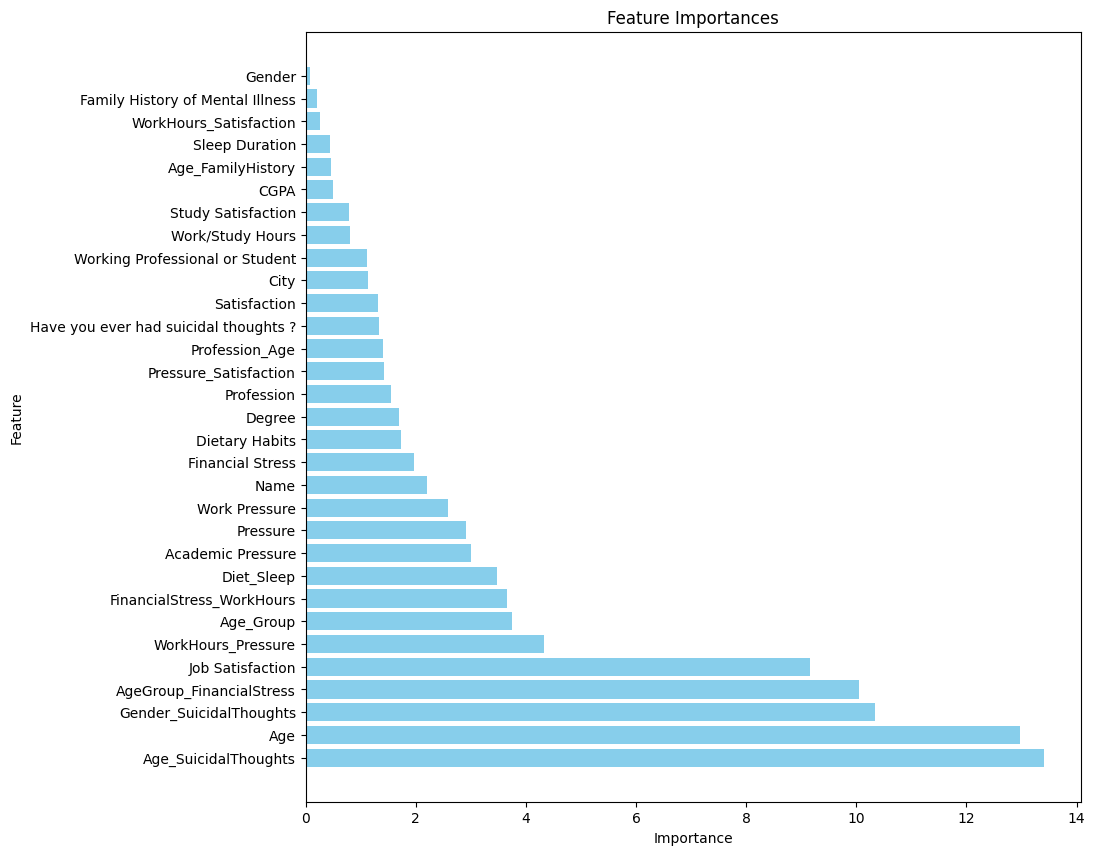

['Age_SuicidalThoughts' 'Age' 'Gender_SuicidalThoughts'
 'AgeGroup_FinancialStress' 'Job Satisfaction' 'WorkHours_Pressure'
 'Age_Group' 'FinancialStress_WorkHours' 'Diet_Sleep' 'Academic Pressure']


In [ ]:
# Get feature importances
feature_importances = model.get_feature_importance(prettified=True)
# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.barh(
    feature_importances["Feature Id"],
    feature_importances["Importances"],
    color="skyblue",
)

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")

plt.show()


# select top 10 features
top_features = feature_importances["Feature Id"][:10].values

print(top_features)

In [ ]:
# Save predictions
submission = pd.read_csv(path_data / "sample_submission.csv")

submission["Depression"] = y_test_pred

submission.to_csv(path_data / "submission.csv", index=False)

submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
